In [ ]:
import plotly.express as px
import pandas as pd
import numpy as numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
hongos = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/secondary_data.csv", sep=";")


# Nans:


**Las siguientes variables cuentan con valores de Nan y seran reemplazadas. Como regla general, se utilizara other cuando se puede asegurar que tiene valor y unknown cuando no se sabe si siquiera ese dato podria tener valor (caso de color/forma de cosas que no se sabe siquiera si lo tiene, etc).**


- Cap surface: como es un dato que obligatoriamente tiene cualquier hongo, voy   a tomar los nan y los "d" (debido a que es un valor no especificado en el paper) como otros = "o"

- gill-attachment: El nan se especifica que es desconocido por el paper (unknown=?) asi que sera reemplazado por "u".

- Gill-Spacing:
  1. Para los hongos que tienen gill-attachment none (f): se reemplazara por f. Esto se ve respaldado por el hecho que todos los hongos que no tienen gill.attachment y tienen gill-spacing conocido tienen valor f, no puede tener spacing si no tiene gills.

  2. Para los hongos que tienen gill-attachment distinto a u/f: seran reemplazados por others = "o" puesto que se sabe que si tienen gills, solo que no se sabe el spacing.

  3. Para los que no se sabe si tienen gill-attachment (u), se utilizara unknown = "u".

- Stem-Root: existe un valor desconocido, que no aparece en la documentacion (f) y Nans, ambos seran reemplazados por other, puesto que si o si tiene que tener stem.

- Stem-Surface: debido a que todo registro tiene stem-height/width/color es un poco raro que exista la posibilidad de tener none (f) como valor posible, puesto que todo tiene alguna textura de superficie. Para que tengan sentido los nans y los f se utilizara other = "o".

- veil-type: puesto que no puedo asumir que porque ninguno es parcial que alguno de ellos lo es, se reemplazaran los nans de la siguiente forma:
  1. Aquellos que tengan veil-color distinto a Nan o f: other = "o".
  
  2. Aquellos que no se sepa el veil-color: unknown = "n". Se utiliza porque ya existe la u como valor.

- Veil-color:
  1. Si veil-type es unknown: unknown (n, puesto que ya existe u).
  2. Si veil.type es distinto a uknown: other.

- Ring-type: se especifica la existencia de unknown = ?, por lo que sera reemplazado por "u".

- spore-print-color: Nans seran reemplazados por other = "o".


In [ ]:
#Cap surface:
hongos.loc[hongos['cap-surface'] == 'd', 'cap-surface'] = "o"
hongos['cap-surface'] = hongos['cap-surface'].fillna("o")

#gill-attachment:
hongos['gill-attachment'] = hongos['gill-attachment'].fillna("u")

#gill-spacing
hongos.loc[(hongos['gill-attachment'] == 'f') & (hongos['gill-spacing'].isnull()), 'gill-spacing'] = "f"
hongos.loc[(hongos['gill-attachment'] == 'u') & (hongos['gill-spacing'].isnull()), 'gill-spacing'] = "u"
hongos['gill-spacing'] = hongos['gill-spacing'].fillna("o")

#Stem-Root:
hongos.loc[hongos['stem-root'] == 'f', 'stem-root'] = "o"
hongos['stem-root'] = hongos['stem-root'].fillna("o")

#stem-surface
hongos.loc[hongos['stem-surface'] == 'f', 'stem-surface'] = "o"
hongos['stem-surface'] = hongos['stem-surface'].fillna("o")

#Veil-Type (noto que veil-color no tiene f, solo nan)
hongos.loc[(hongos['veil-color'].notnull()) & (hongos['veil-type'].isnull()), 'veil-type'] = "o"
hongos['veil-type'] = hongos['veil-type'].fillna("n") #ya existe u

#Veil-color
hongos.loc[(hongos['veil-type'] == 'n') & (hongos['veil-color'].isnull()), 'veil-color'] = "n" #ya existe u
hongos['veil-color'] = hongos['veil-color'].fillna("n")

#ring-type:
hongos['ring-type'] = hongos['ring-type'].fillna("u")

#Spore-print-color:
hongos['spore-print-color'] = hongos['spore-print-color'].fillna("o")


# Separar datos

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x = hongos.drop('class', axis=1)
y = hongos['class']

In [ ]:
x = x.astype({"stem-height":"float","stem-width":"float","cap-diameter":"float"})

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
x[['stem-height','stem-width','cap-diameter']] = pd.DataFrame(scaler.fit_transform(x[['stem-height','stem-width','cap-diameter']]), columns=[['stem-height','stem-width','cap-diameter']])

Train: 80%
Test: 10%
Validation: 10%

In [ ]:
x_train, x_separar, y_train, y_separar = train_test_split(x, y, test_size=0.2, random_state=5)

In [ ]:
x_test, x_validation, y_test, y_validation = train_test_split(x_separar, y_separar, test_size=0.5, random_state=5)

# Encoding

Realizo el encoding de test, validation y train por separado asi no filtro datos. Se eligieron los encoders Binary Encoder y OHE.


In [ ]:
from sklearn.preprocessing import OneHotEncoder
!pip install category_encoders
import category_encoders as ce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
columnas = ['cap-shape','cap-surface','cap-color','gill-attachment','gill-spacing','gill-color','stem-root','stem-surface','stem-color',
            'veil-type','veil-color','ring-type','spore-print-color','habitat','season']
for columna in columnas:
  encoder = ce.BinaryEncoder(cols=[columna])
  x_train = encoder.fit_transform(x_train)

  x_test = encoder.transform(x_test)
  x_validation = encoder.transform(x_validation)

In [ ]:
#bleed
ohe_bleed = OneHotEncoder(drop='first')
x_train['does-bruise-or-bleed'] = ohe_bleed.fit_transform(x_train[['does-bruise-or-bleed']]).todense().astype(int)

x_test['does-bruise-or-bleed'] = ohe_bleed.transform(x_test[['does-bruise-or-bleed']]).todense().astype(int)
x_validation['does-bruise-or-bleed']= ohe_bleed.transform(x_validation[['does-bruise-or-bleed']]).todense().astype(int)


In [ ]:
# has-ring
ohe_ring = OneHotEncoder(drop='first')
x_train['has-ring'] = ohe_ring.fit_transform(x_train[['has-ring']]).todense().astype(int)

x_test['has-ring'] = ohe_ring.transform(x_test[['has-ring']]).todense().astype(int)
x_validation['has-ring']= ohe_ring.transform(x_validation[['has-ring']]).todense().astype(int)


Encodeo target

In [ ]:
#class
class_OHE = ce.OneHotEncoder(cols=['class'])

y_train = class_OHE.fit_transform(y_train).iloc[:, 0]

y_test =  class_OHE.transform(y_test).iloc[:, 0]
y_validation =  class_OHE.transform(y_validation).iloc[:, 0]


# Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score

In [ ]:
random_forest = RandomForestClassifier(random_state=0)
random_forest.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
validation_proba = random_forest.predict_proba(x_validation)[:,1]
roc_auc_score(y_validation, validation_proba)

1.0

Roc-Auc obtenido = 1.0
Debido a que ya se alcanza el roc-auc 1, no busco hiperparametros

# Importancia de Features


Graficar la importancia de features para el Random Forest de la parte III. ¿Qué tanto se parece a los features importantes de la parte II?

                 Feature  Importancia
9             stem-width     0.099465
5        gill-attachment     0.086765
12            stem-color     0.081999
7             gill-color     0.076945
2            cap-surface     0.075358
6           gill-spacing     0.068945
0           cap-diameter     0.062745
11          stem-surface     0.061571
8            stem-height     0.060211
3              cap-color     0.053040
10             stem-root     0.046422
1              cap-shape     0.044456
16             ring-type     0.038666
18               habitat     0.025341
17     spore-print-color     0.024228
4   does-bruise-or-bleed     0.022921
19                season     0.019755
13             veil-type     0.018233
15              has-ring     0.017661
14            veil-color     0.015271


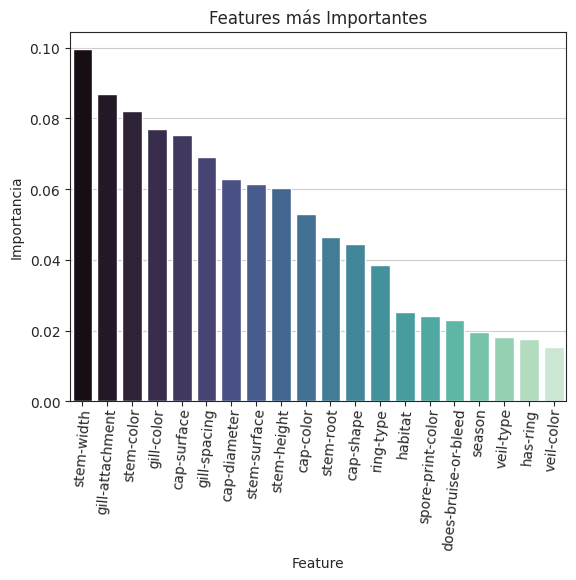

In [ ]:
import seaborn as sns
import numpy as np
from matplotlib import rcParams

k_mas_importantes = 20 #cantidad de features q se quieren mostrar, max = 20
coefs = random_forest.feature_importances_

importancia = {}
for i in range (len(coefs)):
  key_act = x_train.columns[i]
  if (key_act[-2] == "_"):
    key_act = key_act[0:-2]
  if key_act not in importancia.keys():
    importancia[key_act] = abs(coefs[i])
  else:
    importancia[key_act] += abs(coefs[i])

grafico = pd.DataFrame({'Feature':importancia.keys(), 'Importancia':importancia.values()})
grafico = grafico.reindex(grafico.Importancia.abs().sort_values(ascending=False).index)

#Bar plot
sns.set_style("ticks",{'axes.grid' : True})
bar = sns.barplot(data = grafico.iloc[0:k_mas_importantes], x = 'Feature', y='Importancia', palette = "mako")
bar.tick_params(axis='x', rotation=85, pad = 0.5)
bar.set(title="Features más Importantes")
print(grafico)

Entre las diferencias que tienen los graficos, se puede ver que, en el caso de la regresion logistica, suele haber un salto muy grande entre los primeros valores (21,17,11,8 y luego hay tres grupos principales, rondando el 2, el 1 y el 0), mientras que en el random forest, tiene una forma mas escalonada con diferencias menores entre importancias.


A su vez  se puede ver que la diferencia entre la importancia del feature mas importante y el menos importante es muchisimo menor en este caso. En la regresion logistica la menos importante ronda el 0, mientras que en forest todas muestran algun grado de importancia.


Finalmente otra diferencia apreciable, es que en el random forest se tienen mucho mas en cuenta las features numericas, tales como las altura, anchos, diametros, etc.. En este caso, la primera y quinta features mas importante es numerica, seguido de otras 4 features del mismo tipo. Por otro lado, en la regresion logistica los features numericos suelen tener menor importancia, siendo el primer feature numerico el 5to mas importante, con casi un tercio de la importancia del primero, y recien aparece de nuevo un feature numerico en el 10mo valor.
